<div style="font-family: Arial, sans-serif; padding: 10px; border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9;">
        <h2 style="color: #333;">Welcome to the Stock Video Metadata Generator (Google Colab Instructions)</h2>
        <p style="color: #555; font-size: 16px;">
            This platform helps you generate a title, description, and 50 keywords for your stock video.
            You simply need to upload any number of video files, and the system will automatically analyze it to provide you with the best metadata
            for describing your videos on stock footage platforms.
        </p>
        <p style="color: #555; font-size: 16px;">
            More information on this project can be found on the <a href='https://github.com/JeremiahGiordani/Metadata-Generator'>Github</a>
        </p>
        <h3 style="color: #333;">How to Use:</h3>
        <ol style="color: #555; font-size: 16px;">
            <li>Make a copy of this notebook in your Google Drive (File > Save Copy in Drive)</li>
            <li>In the codebox below, paste your OpenAI API key inside the quotes</li>
            <li>Click on the "File" icon on the left panel to upload your video files. (This might take a little while, so be sure to wait until the videos are completely uploaded.)</li>
            <li>In the codebox below, paste your OpenAI API key inside the quotes</li>
            <li>Once the file is uploaded, click the "Runtime" tab and click "Run All" </li>
            <li>Scroll down to the output. You will see a checklist of the available video files. Select the videos you wish to process by checking the corresponding boxes.</li>
            <li>Once you have made your selections, click the "Generate" button to start the analysis.</li>
            <li>After the analysis is complete, you will see the output, which includes the video title, description, and 50 keywords.</li>
            <li>You can easily copy the title, description, and keywords from the output for your use.</li>
            <li>You can also view the output file by clicking on the "Files" icon on the left panel. If you don't see the file immediately, try refreshing the file list. Once you locate the output file - video_metadata_output.txt - you can click on it to download and save it to your local machine.</li>
        </ol>

</div>


<h3> Paste your OpenAI API Key below</h3>

In [ ]:
OPENAI_API_KEY = ""

<h2>Imports</h2>

In [1]:
from google.colab import files
import ipywidgets as widgets
import base64
import requests
import json
import os
import time
from moviepy.editor import VideoFileClip
from PIL import Image
from io import BytesIO
from IPython.display import display, Image as IPImage, HTML

<h2>Supports video selection feature</h2>

In [ ]:
# Function to find all .mp4 and .mov files in the runtime
def find_video_files():
    video_files = []
    for file in os.listdir('/content'):
        if file.endswith('.mp4') or file.endswith('.mov') or file.endswith('.MP4') or file.endswith('.MOV'):
            video_files.append(file)
    return video_files

# Function to display checkboxes for the found video files
def display_video_checklist(video_files):
    checkboxes = ""
    for video in video_files:
        checkboxes += f'<input type="checkbox" name="video" value="{video}"> {video}<br>'

    display(HTML(f"""
        <div style="font-family: Arial, sans-serif; padding: 10px; border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9;">
            <h3 style="color: #333;">Select Videos to Process:</h3>
            <form id="videoForm">
                {checkboxes}
                <br>
                <button type="button" onclick="generateSelected()">Generate</button>
            </form>
        </div>
    """))

<h2> Splits videos</h2>

In [ ]:
def extract_images_from_video(video_path, num_images=5):
    video = VideoFileClip(video_path)
    duration = video.duration
    timestamps = [duration * i / (num_images + 1) for i in range(1, num_images + 1)]

    images = []
    for timestamp in timestamps:
        frame = video.get_frame(timestamp)
        img = Image.fromarray(frame)
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
        images.append(img_str)

        # Display the image in the notebook
        display(IPImage(data=buffered.getvalue(), width=300, height=200))

    return images

<h2>Handles API requests</h2>

In [ ]:
def construct_messages(images):
    messages = []

    system_message = {
        "role": "system",
        "content": (
            "You are a helpful assistant. Your task is to generate a title, description, and 50 keywords "
            "to describe a video for a stock footage platform. You will be provided with 5 evenly spaced images "
            "from the video. Use these images to understand the content of the video and generate relevant keywords. "
            "Return the title, description, and keywords in a JSON format, with the title in a field called 'title', "
            "the description in a field called 'description', and all 50 keywords in a field called 'keywords'. "
            "In your keywords, be sure to describe what is in the video, as well as any videographic qualities about the video. "
            "For example, if it's a drone video, be sure to include keywords about the drone. If it's a time-lapse, slow-motion, "
            "or aerial shot, include those characteristics. Additionally, note any prominent colors, moods, or specific actions "
            "occurring in the video. Your keywords should cover both the content and the style of the video, ensuring they are "
            "comprehensive and relevant for stock footage purposes. The title should be concise and descriptive, while the "
            "description should provide a brief overview of what the video contains and any notable qualities or themes."
            "The description MUST be between 150 and 250 characters in length, so be sure to give only two or three sentences!"
        )
    }

    messages.append(system_message)

    for i, img in enumerate(images, start=1):
        image_message = {
            "role": "user",
            "content": [
                {"type": "text", "text": f"Here is image {i}:"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{img}"
                    }
                }
            ]
        }
        messages.append(image_message)

    return messages

def send_request_to_llm(messages):
    # Try to pull the API key from the environment, otherwise use the predefined value
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY', OPENAI_API_KEY)

    api_url = "https://api.openai.com/v1/chat/completions"
    api_key = OPENAI_API_KEY
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    payload = {
        "model": "gpt-4o-mini",
        "messages": messages
    }

    response = requests.post(api_url, headers=headers, data=json.dumps(payload))
    response_data = response.json()
    return response_data

def parse_response(response_data):
    response_message = response_data.get('choices', [])[0].get('message', {}).get('content', {})
    return response_message




<h2> Handles output (display output and file output)</h2>

In [ ]:
# Function to append the metadata to the pipe-delimited text file, removing old entries if needed
def append_to_output_file(filename, title, description, keywords):
    output_file_path = '/content/video_metadata_output.txt'
    # Read the current content of the file if it exists
    if os.path.exists(output_file_path):
        with open(output_file_path, 'r') as f:
            lines = f.readlines()
    else:
        lines = []

    # Filter out any existing entry with the same filename
    lines = [line for line in lines if not line.startswith(f"{filename}|")]

    # Add the new entry
    lines.append(f"{filename}|{title}|{description}|{keywords}\n")

    # Write the updated content back to the file
    with open(output_file_path, 'w') as f:
        f.writelines(lines)

def display_output(video, title, description, keywords):
    display(HTML(f"""
        <div style="font-family: Arial, sans-serif; padding: 10px; border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9; margin-bottom: 20px;">
            <h3 style="color: #333;">Video:</h3>
            <p style="color: #555; font-size: 16px;">{video}</p>
        </div>
    """))
    print("\n" + "="*50 + "\n")
    display(HTML(f"""
        <div style="font-family: Arial, sans-serif; padding: 10px; border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9; margin-bottom: 20px;">
            <h3 style="color: #333;">Title:</h3>
            <p style="color: #555; font-size: 16px;">{title}</p>
        </div>
    """))
    display(HTML(f"""
      <button onclick="navigator.clipboard.writeText('{title}').then(function() {{ alert('Copied title to clipboard!'); }})">
        Copy <strong>Title</strong> to Clipboard
      </button>
    """))
    print("\n" + "="*50 + "\n")
    display(HTML(f"""
        <div style="font-family: Arial, sans-serif; padding: 10px; border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9; margin-bottom: 20px;">
            <h3 style="color: #333;">Description:</h3>
            <p style="color: #555; font-size: 16px;">{description}</p>
        </div>
    """))
    display(HTML(f"""
      <button onclick="navigator.clipboard.writeText('{description}').then(function() {{ alert('Copied description to clipboard!'); }})">
        Copy <strong>Description</strong> to Clipboard
      </button>
    """))
    print("\n" + "="*50 + "\n")
    display(HTML(f"""
        <div style="font-family: Arial, sans-serif; padding: 10px; border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9; margin-bottom: 20px;">
            <h3 style="color: #333;">Keywords:</h3>
            <p style="color: #555; font-size: 16px;">{keywords}</p>
        </div>
    """))
    display(HTML(f"""
      <button onclick="navigator.clipboard.writeText('{keywords}').then(function() {{ alert('Copied keywords to clipboard!'); }})">
        Copy <strong>Keywords</strong> to Clipboard
      </button>
    """))

<h2>Runs the program</h2>

Processing: DJI_0892.MP4


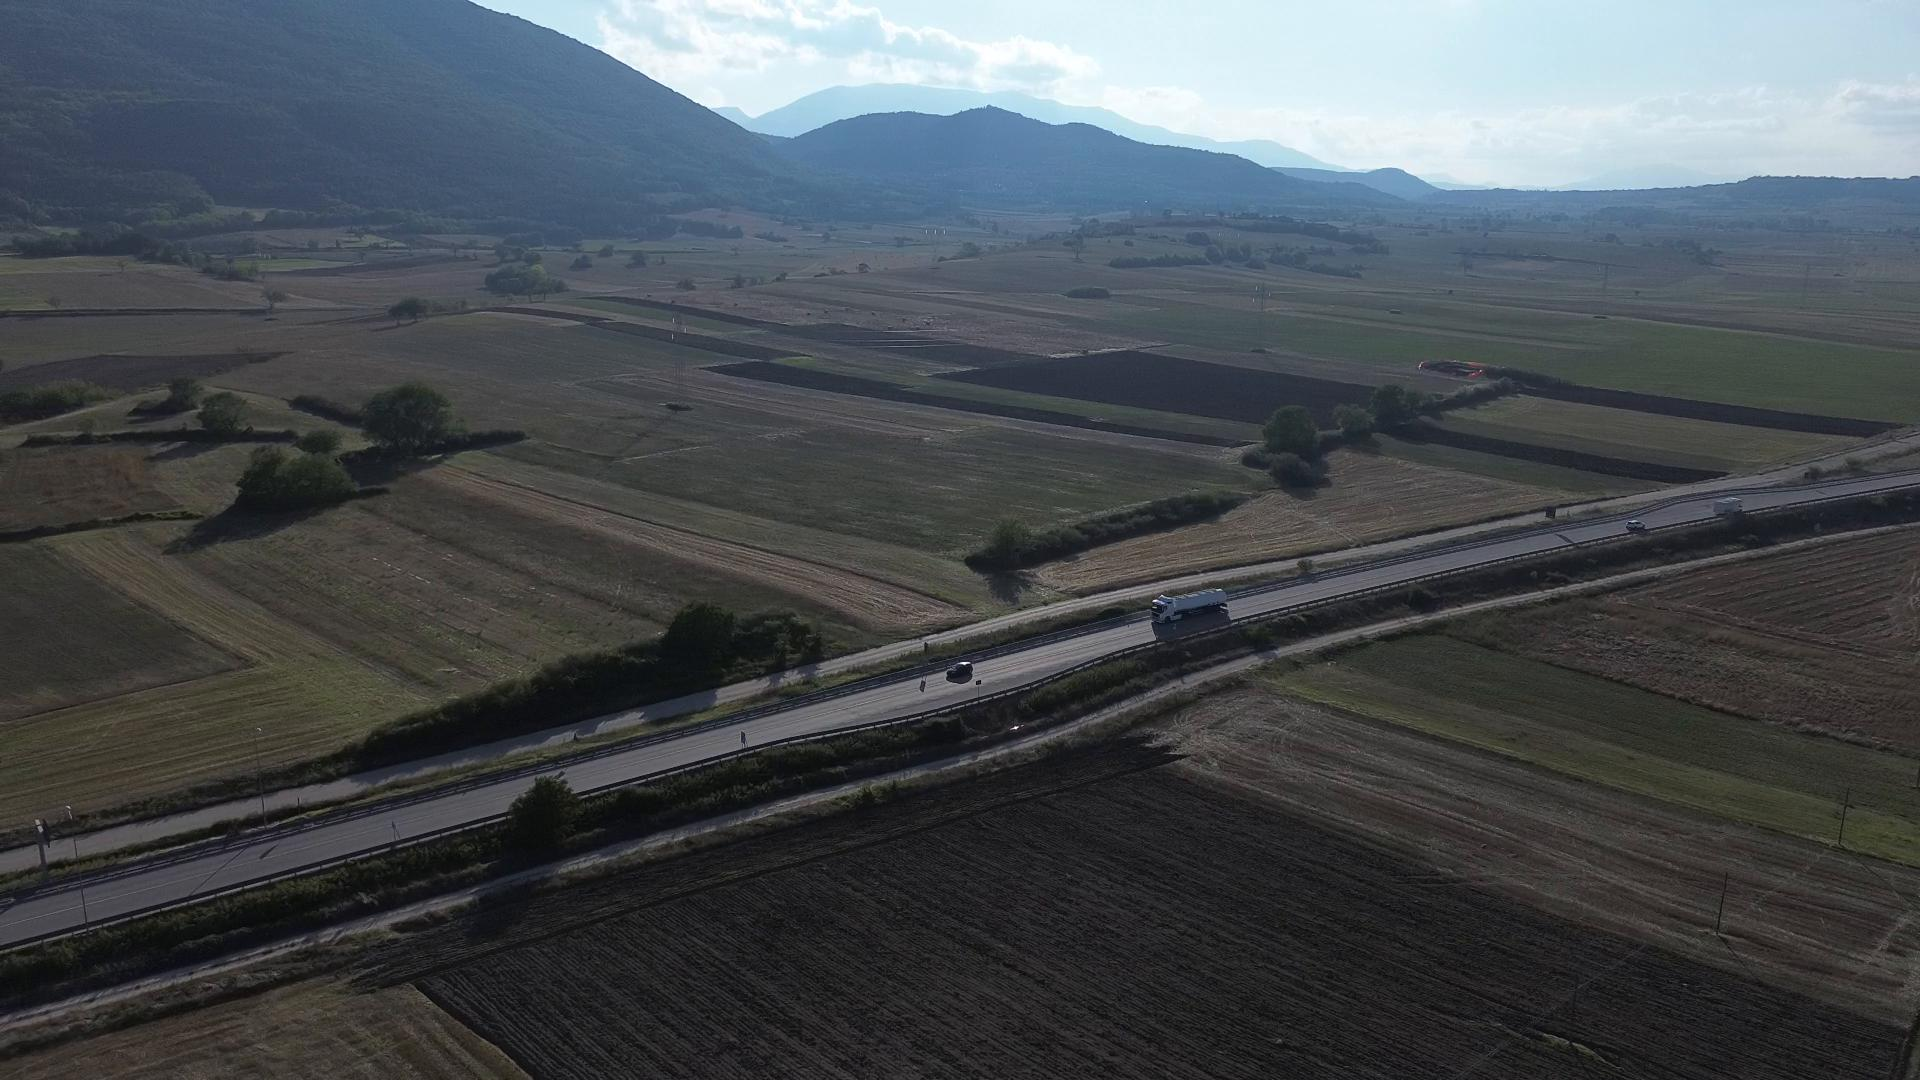

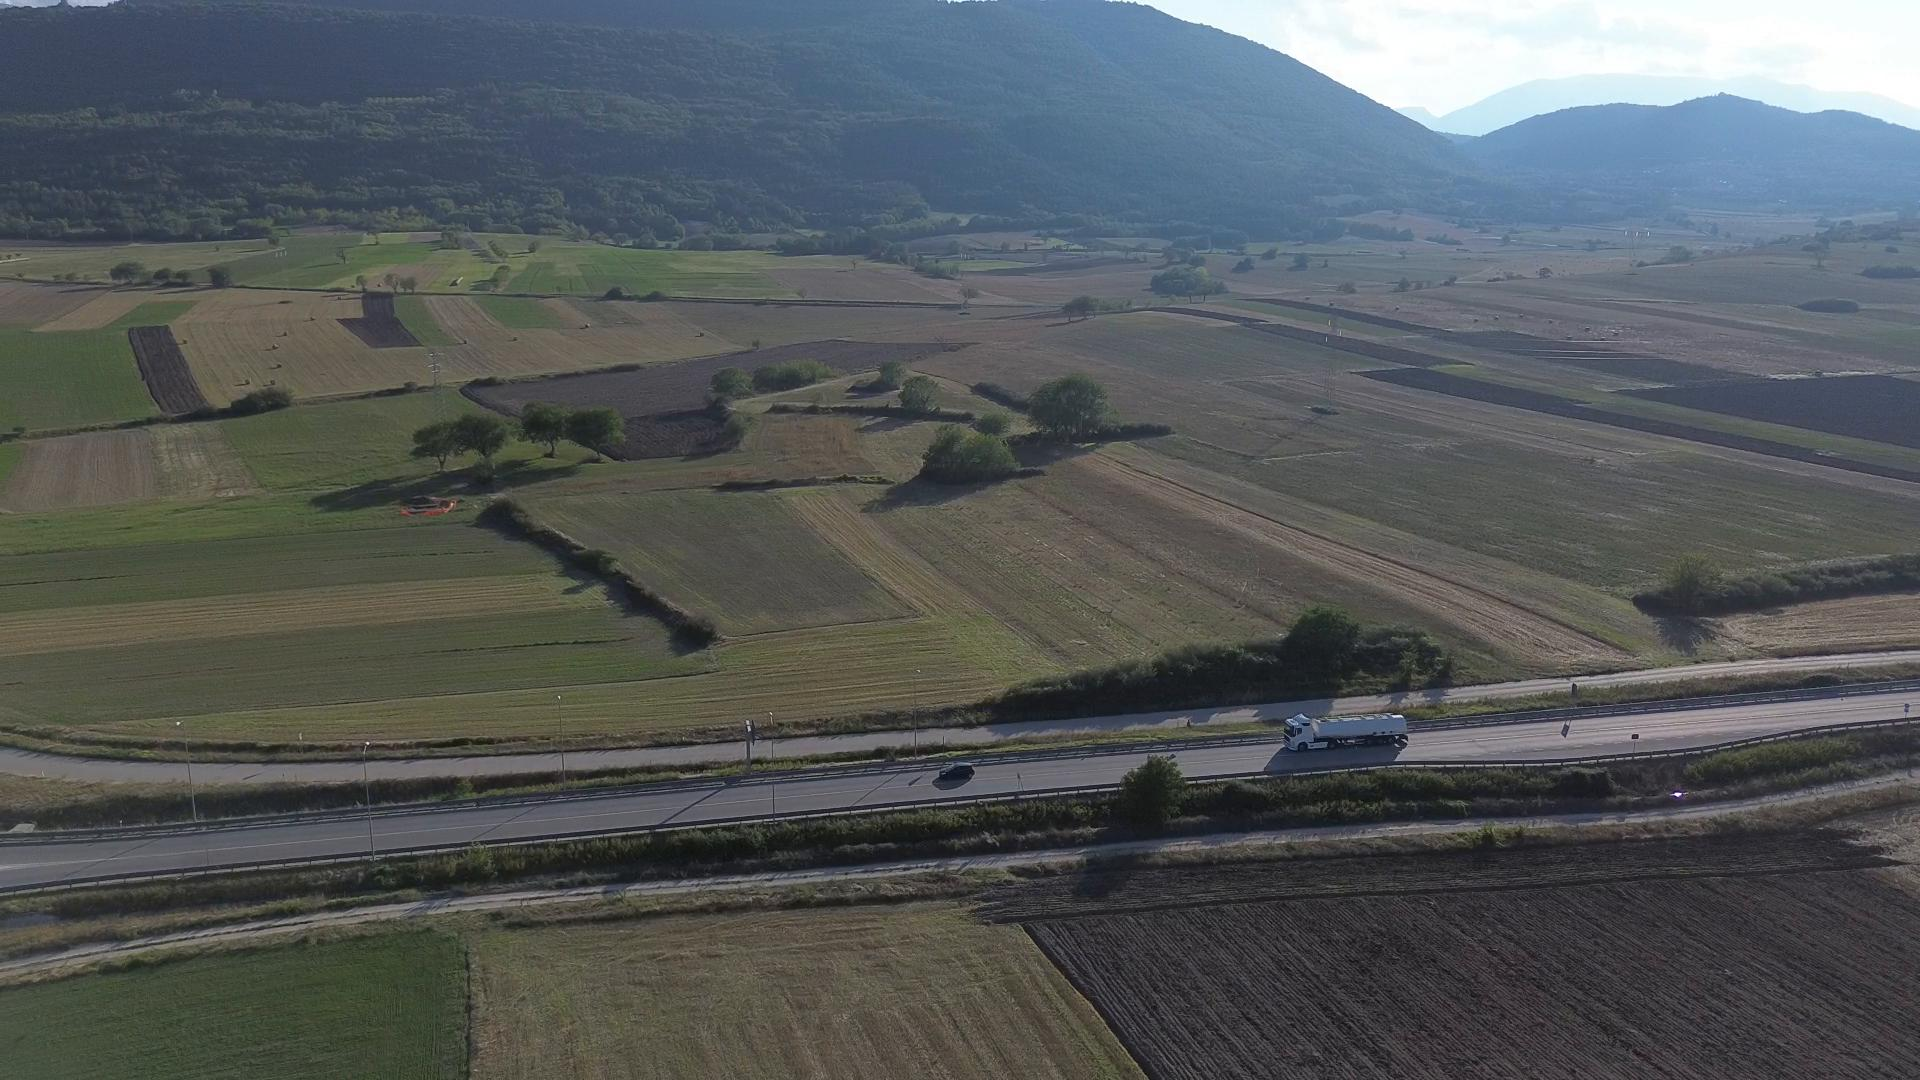

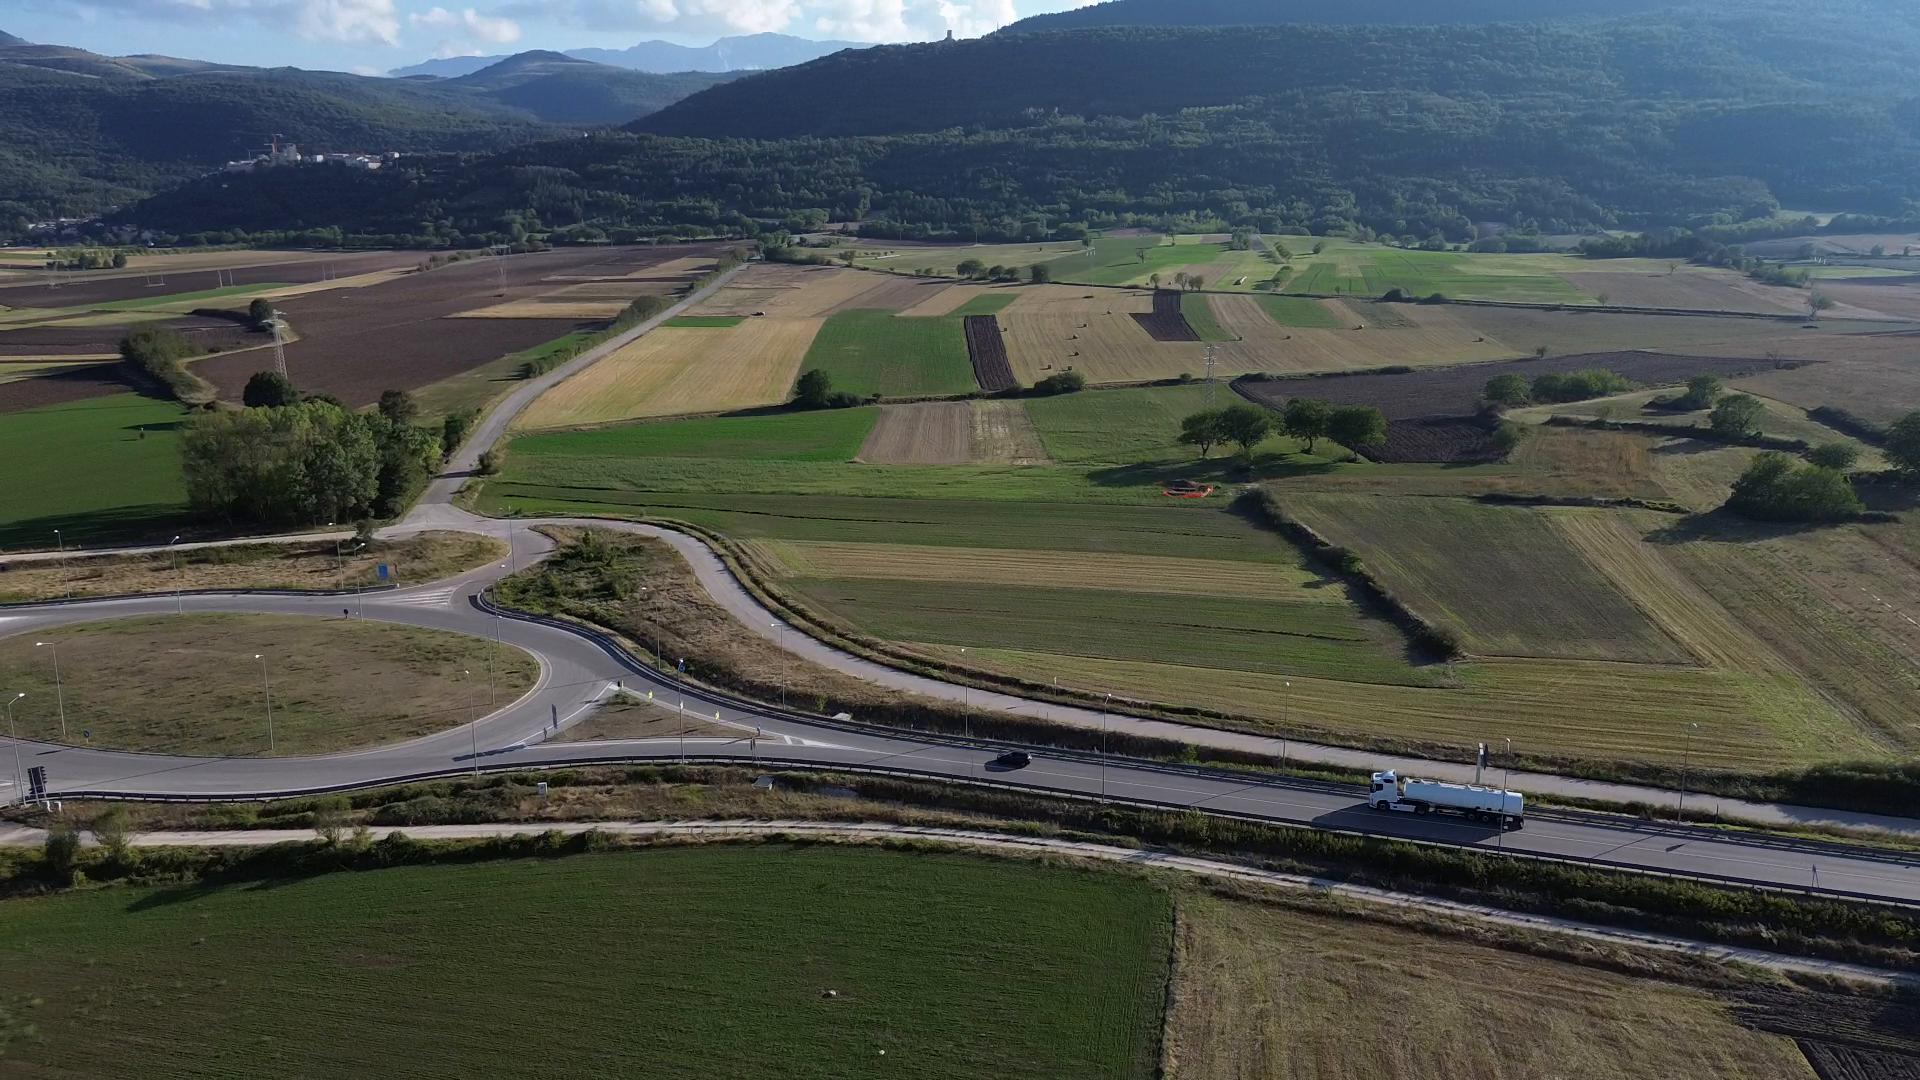

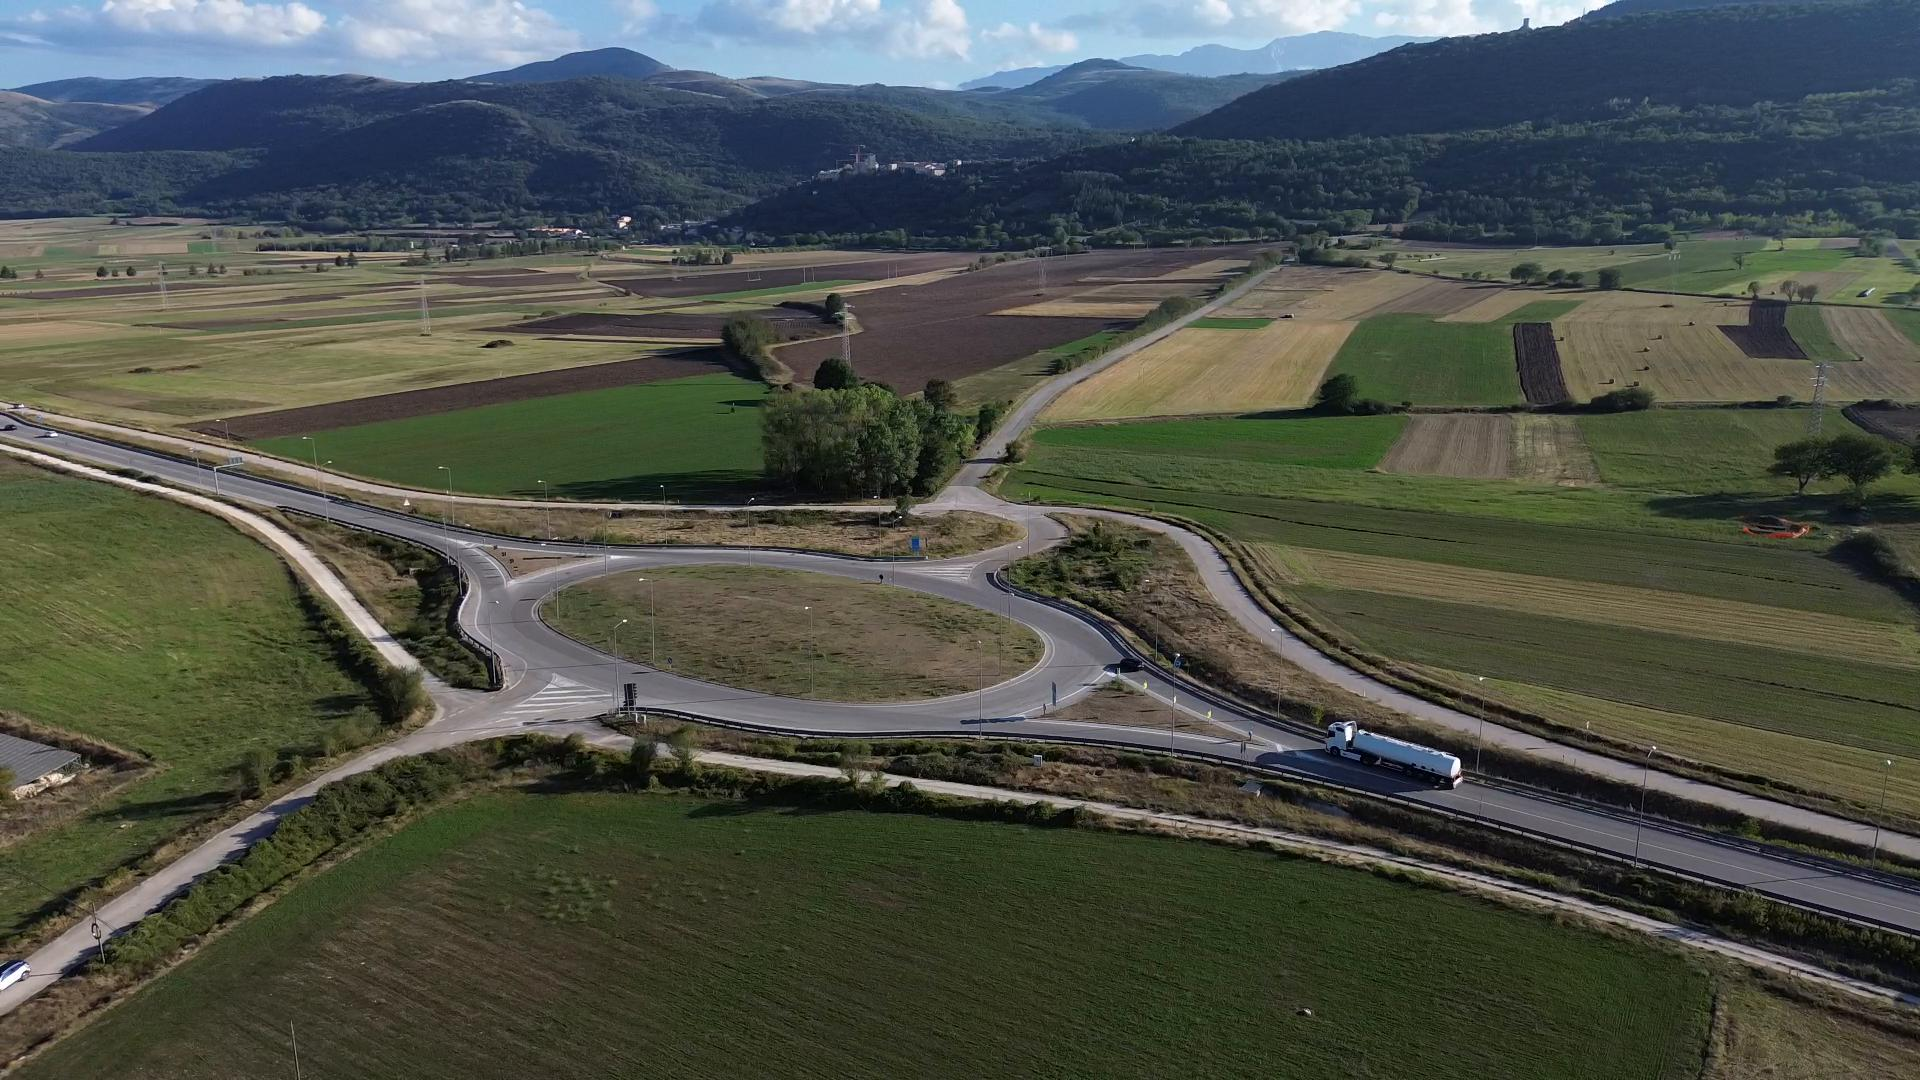

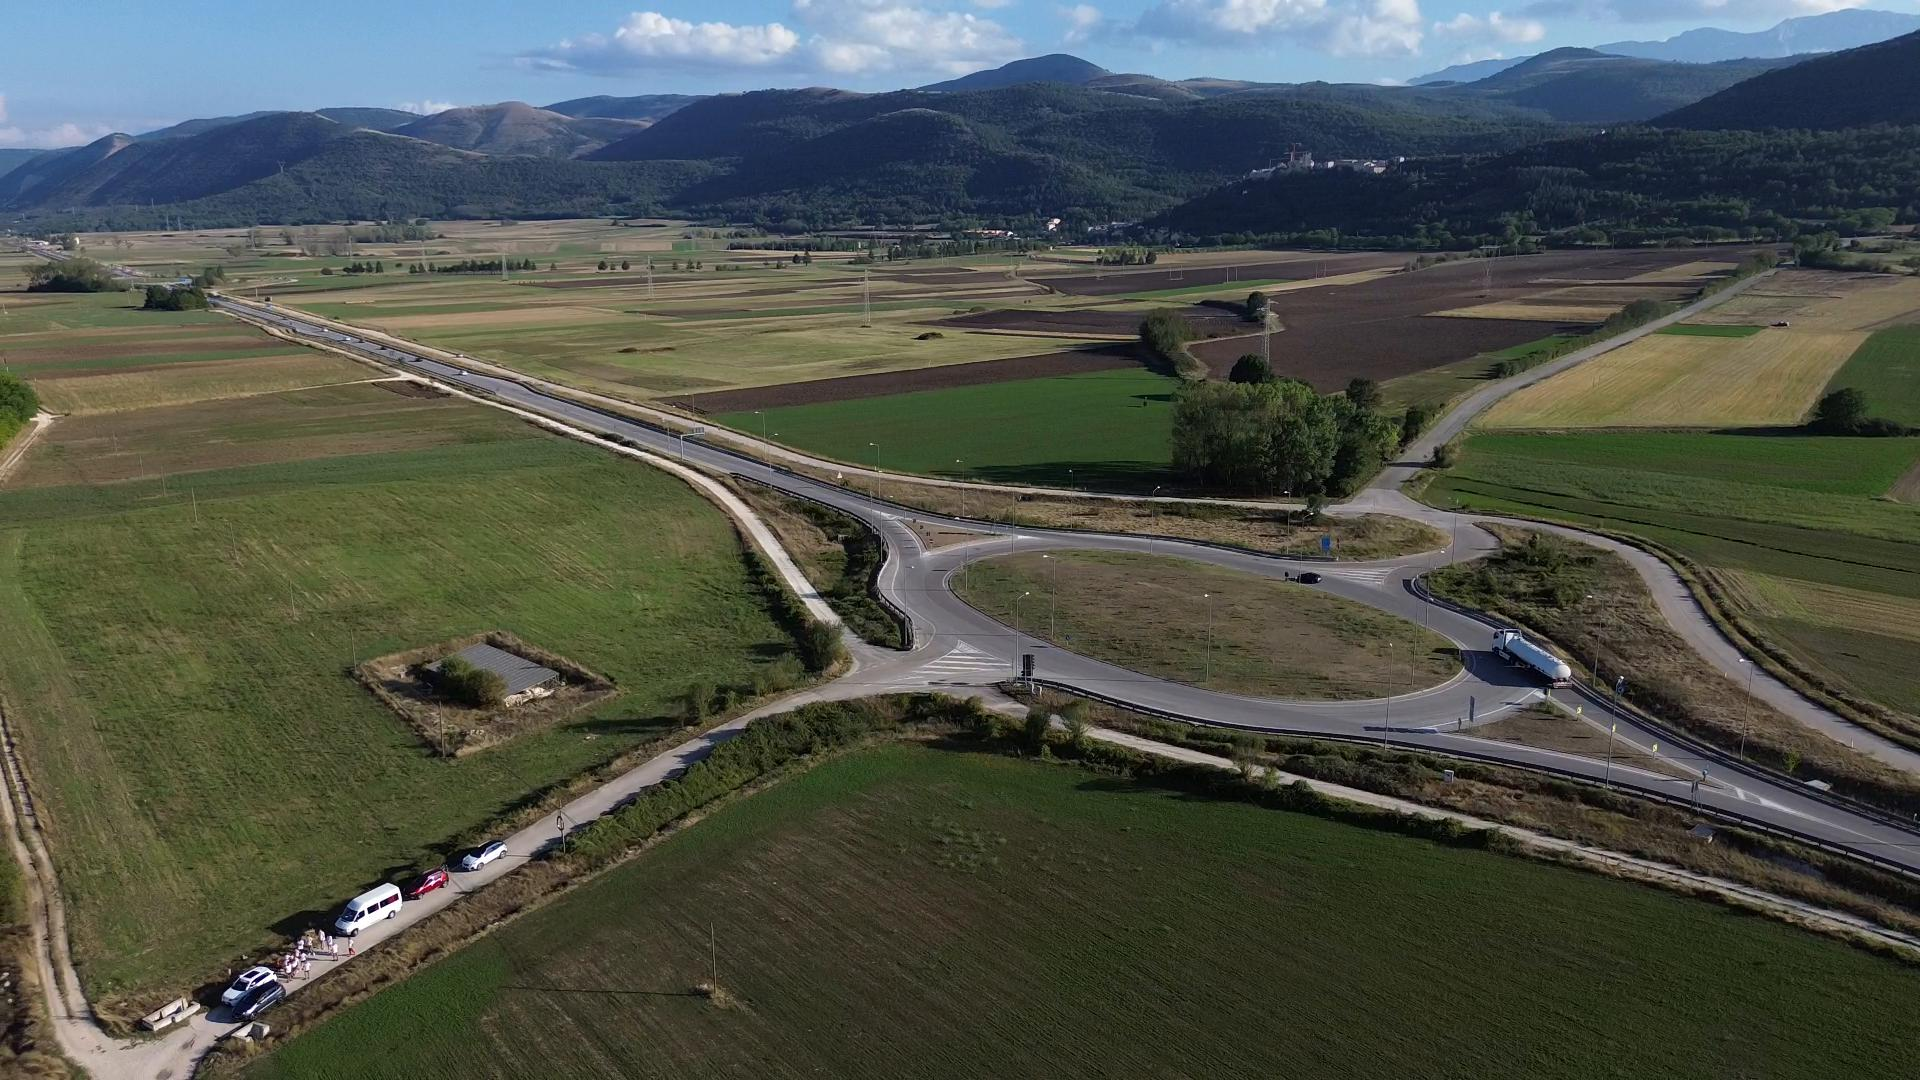

Generating metadata ...


Process completed: output written to output file


In [ ]:
# Function to parse LLM response
def parse_json_response(response_message, video):
    json_start = response_message.find('{')
    json_end = response_message.rfind('}') + 1
    json_string = response_message[json_start:json_end]

    try:
        json_response = json.loads(json_string)
        title = json_response.get('title', '')
        description = json_response.get('description', '')
        keywords = json_response.get('keywords', [])
        cleaned_keywords = ', '.join(keywords)
        append_to_output_file(video, title, description, cleaned_keywords)
        display_output(video, title, description, cleaned_keywords)
        return
    except json.JSONDecodeError:
        json_response = None
        return json_response

# Function to generate metadata for selected videos
def generate_metadata(video_files):
    for video in video_files:
        print(f"Processing: {video}")
        images = extract_images_from_video(f'/content/{video}')
        messages = construct_messages(images)
        print("Generating metadata ...")
        response_data = send_request_to_llm(messages)
        response_message = parse_response(response_data)
        parse_json_response(response_message, video)
    print("Process completed: output written to output file")

# Function to handle the button click event
def on_button_click(b):
    selected_videos = [cb.description for cb in checkboxes if cb.value]
    if selected_videos:
        generate_metadata(selected_videos)
    else:
        print("Please select at least one video to process.")

video_files = find_video_files()
checkboxes = [widgets.Checkbox(value=False, description=video) for video in video_files]
generate_button = widgets.Button(description="Generate")

generate_button.on_click(on_button_click)

# Display the checkboxes and the generate button
display(widgets.VBox(checkboxes))
display(widgets.HBox([generate_button]))